In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [2]:
# Define directories for training and testing datasets
train_dir = 'C:\\Users\\sugam\\Desktop\\mri-images\\Training'
test_dir = 'C:\\Users\\sugam\\Desktop\\mri-images\\Testing'

# Load and shuffle the train data
train_paths, train_labels = [], []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths, test_labels = [], []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

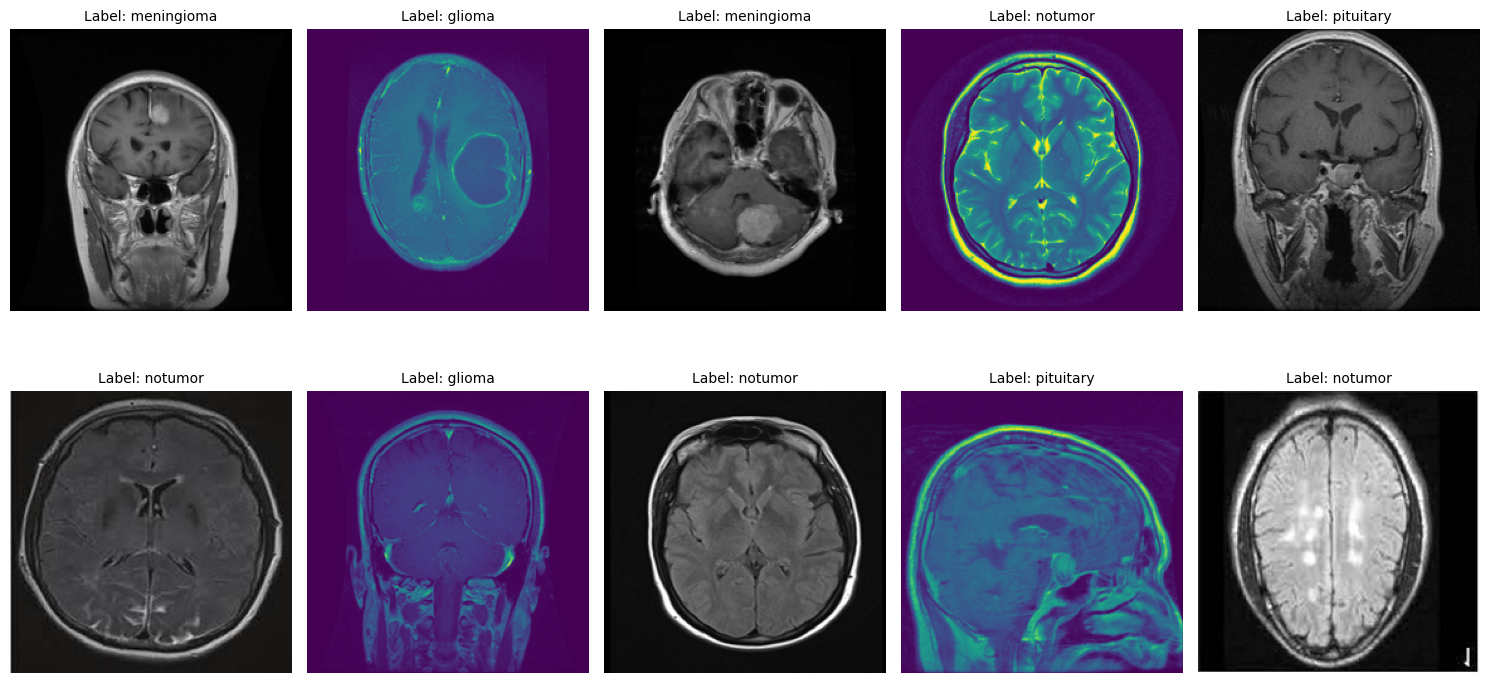

In [3]:
# Display random images with labels
random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img = Image.open(train_paths[idx]).resize((224, 224))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0  # Normalize pixel values

# Load and preprocess images
def open_images(paths, image_size=128):
    images = []
    for path in paths:
        image = load_img(path, target_size=(image_size, image_size))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encode labels
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))  # Ensures correct label order
    return np.array([unique_labels.index(label) for label in labels])

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_images = open_images(paths[i:i + batch_size])
            batch_labels = encode_label(labels[i:i + batch_size])
            yield batch_images, batch_labels# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0  # Normalize pixel values

# Load and preprocess images
def open_images(paths, image_size=128):
    images = []
    for path in paths:
        image = load_img(path, target_size=(image_size, image_size))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encode labels
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))  # Ensures correct label order
    return np.array([unique_labels.index(label) for label in labels])

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_images = open_images(paths[i:i + batch_size])
            batch_labels = encode_label(labels[i:i + batch_size])
            yield batch_images, batch_labels

In [5]:
# Define model parameters
IMAGE_SIZE = 128
batch_size = 20
epochs = 5

# Load the VGG16 model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model layers

# Unfreeze last few layers for fine-tuning
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Train the model
steps_per_epoch = len(train_paths) // batch_size
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/5
285/285 [==============================] - 181s 633ms/step - loss: 0.4484 - sparse_categorical_accuracy: 0.8304
Epoch 2/5
285/285 [==============================] - 180s 633ms/step - loss: 0.2311 - sparse_categorical_accuracy: 0.9136
Epoch 3/5
285/285 [==============================] - 180s 632ms/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9385
Epoch 4/5
285/285 [==============================] - 180s 633ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9548
Epoch 5/5
285/285 [==============================] - 180s 630ms/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9671


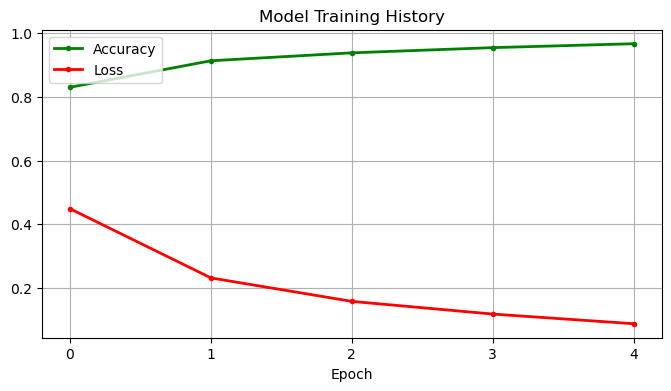

In [6]:
# Plot accuracy and loss
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks(range(epochs))
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

41/41 [==============================] - 33s 795ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       300
           1       0.90      0.94      0.92       306
           2       0.99      0.99      0.99       405
           3       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

Confusion Matrix:
[[271  27   0   2]
 [  5 288   3  10]
 [  4   2 399   0]
 [  0   2   0 298]]


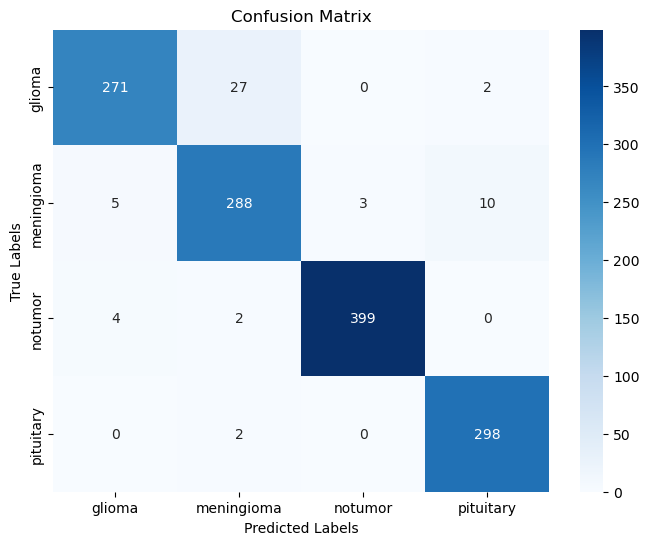

In [7]:
# Evaluate on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)
test_predictions = model.predict(test_images)

# Classification report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(os.listdir(train_dir)),
            yticklabels=sorted(os.listdir(train_dir)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [8]:
# Save the trained model
model.save('model.h5')

In [9]:
# Load the trained model
model = load_model('model.h5')

41/41 [==============================] - 33s 805ms/step


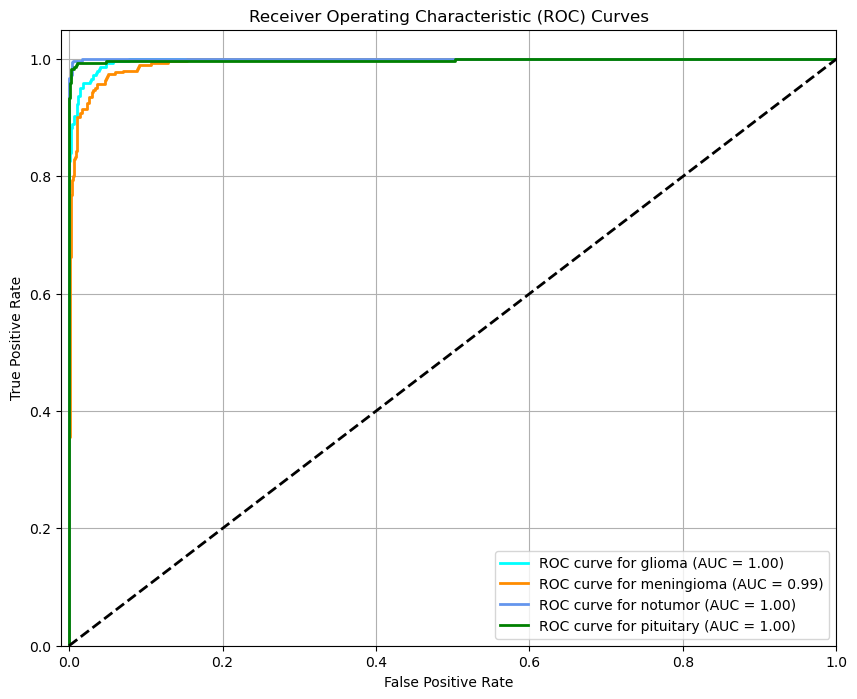

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Step 1: One-hot encode the test labels
class_labels = sorted(os.listdir(train_dir))
n_classes = len(class_labels)
y_test_binarized = label_binarize(test_labels_encoded, classes=range(n_classes))

# Step 2: Predict probabilities for each class
y_score = model.predict(test_images)

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [11]:
# Dynamically retrieve class labels
class_labels = sorted(os.listdir(train_dir))

def detect_and_display(img_path, model, image_size=128):
    """
    Detect tumor in an MRI scan and display the result.
    If no tumor is detected, it shows "No Tumor".
    Otherwise, it displays the predicted tumor class.
    """
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions)

        # Determine the class
        predicted_label = class_labels[predicted_class_index]

        if predicted_label.lower() == 'notumor':  # Ensure proper class match
            result = "No Tumor"
        else:
            result = f"Tumor Found: {predicted_label}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 [==============================] - 0s 62ms/step


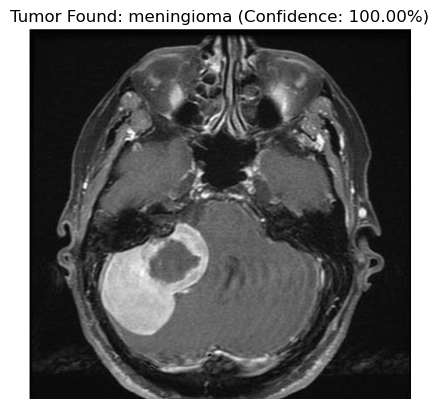

In [15]:
image_path = 'C:\\Users\\sugam\\Desktop\\mri-images\\Testing\\meningioma\\Te-me_0013.jpg'  # Change path if needed
detect_and_display(image_path, model)